In [1]:
import numpy as np
import matplotlib.pyplot as plt
from helpers.descriptors import Section
from os import listdir
from yaml import load
from yaml.loader import Loader
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
import os 

from tqdm import tqdm

from helpers.utils import reorder_points

In [2]:
font = {'family' : 'DejaVu Sans',
        'sans-serif': "Arial",
        'weight' : 'normal',
        'size'   : 18}

mpl.rc('font', **font)
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.major.size'] = 10

In [3]:
BASENAME = "16_Archamps"
PASSAGE = "Meandre"
SECTION = "1"

PROCESSING_PARAMS = f"../../real_data/{BASENAME}/params.yaml"
SECTIONS_FILEPATH = f"../../real_data/{BASENAME}/process/sections_as_polylines/"
PROCESSING_FILEPATH = f"../../real_data/{BASENAME}/process/planes_as_vectors"
params = load(open(PROCESSING_PARAMS), Loader)

GLOBAL_SHIFT = params["alignment"]["globalShift"]

In [4]:
sections = []
sections_fp =[section_fp for section_fp in listdir(SECTIONS_FILEPATH) if f"{PASSAGE}_{SECTION}_unordered" in section_fp]
section_idx = [int(section_fp.strip(".txt").split("_")[-1]) for section_fp in sections_fp]

In [5]:
sections_count = len(sections_fp)

print(sections_count)

35


In [6]:
for section in sections_fp:
    full_fp = os.path.normpath(os.path.join(SECTIONS_FILEPATH, section))
    data = np.loadtxt(full_fp)

    sections.append(data)
    
    

In [7]:
# curvilinear coordinates
planes_origin = np.loadtxt(f"../../real_data/{BASENAME}/process/planes_as_vectors/{PASSAGE}_{SECTION}_Planes_Origin.txt")
curvilinear_pos = np.cumsum(np.linalg.norm(np.diff(planes_origin, axis = 0), axis = 1))
curvilinear_pos = np.pad(curvilinear_pos, (1, 0), "constant", constant_values = (0, 0))

In [8]:
ordered = []
verbose = False
for data, curvilinear_idx in tqdm(zip(sections[:], section_idx), total = len(sections)):
    
    data = reorder_points(data.tolist(), 0)
    dists = np.linalg.norm(np.diff(data, axis = 0), axis = 1)
    id0 = 0
    idx = -1
    if np.any(dists > 1):
        if verbose == True:
            print("likely several segments")
        split = np.argwhere(dists > 0.2).flatten()
        split_data = np.array(np.split(data, split), dtype =object)
        ind = np.argmax(np.array([len(seg) for seg in split_data]))
    
        data = split_data[ind]

    # recentre to barycentre
    data = data - np.mean(data, axis = 0)
    # check if closed: 
    closure = np.linalg.norm(data[-1] - data[0])
    if closure > 0.2:
        #print("there may be a closure error")
        s = Section(data, "ClosureError", curvilinear_pos[curvilinear_idx])
    else: 
        s = Section(data, "all ok", curvilinear_pos[curvilinear_idx])
    ordered.append(s)
    s.compute_descriptors()
    np.savetxt(f"../../real_data/{BASENAME}/process/sections_as_polylines/{PASSAGE}_{SECTION}_reordered_2d_{curvilinear_idx:03d}.txt", s.points2d)


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:01<00:00, 26.07it/s]


In [9]:
# identify flipped ones. 

In [10]:
to_flip = []
for i in tqdm(range(len(ordered)-1)):
    
    # calculate the distance from one to the other. 
    s0 = ordered[i]
    s1 = ordered[i+1]

    diff = np.mean(np.min(np.linalg.norm(np.expand_dims(s0.points2d, 1) - s1.points2d, axis = 2).T, axis = 1))
    flipped = np.vstack([s1.points2d[:, 0], -s1.points2d[:,1]]).T
    diff2 = np.mean(np.min(np.linalg.norm(np.expand_dims(s0.points2d, 1) - flipped, axis = 2).T, axis = 1))
    to_flip.append(np.argmax(np.array([diff, diff2])))

100%|█████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 113.37it/s]


In [11]:
# calculate the distance from one to the other. 
print(np.where(np.array(to_flip) == 0))

(array([], dtype=int64),)


shape of thetai:  (2,)
shape of centroid dist:  (2,)


<AxesSubplot:xlabel='X (m)', ylabel='Y (m)'>

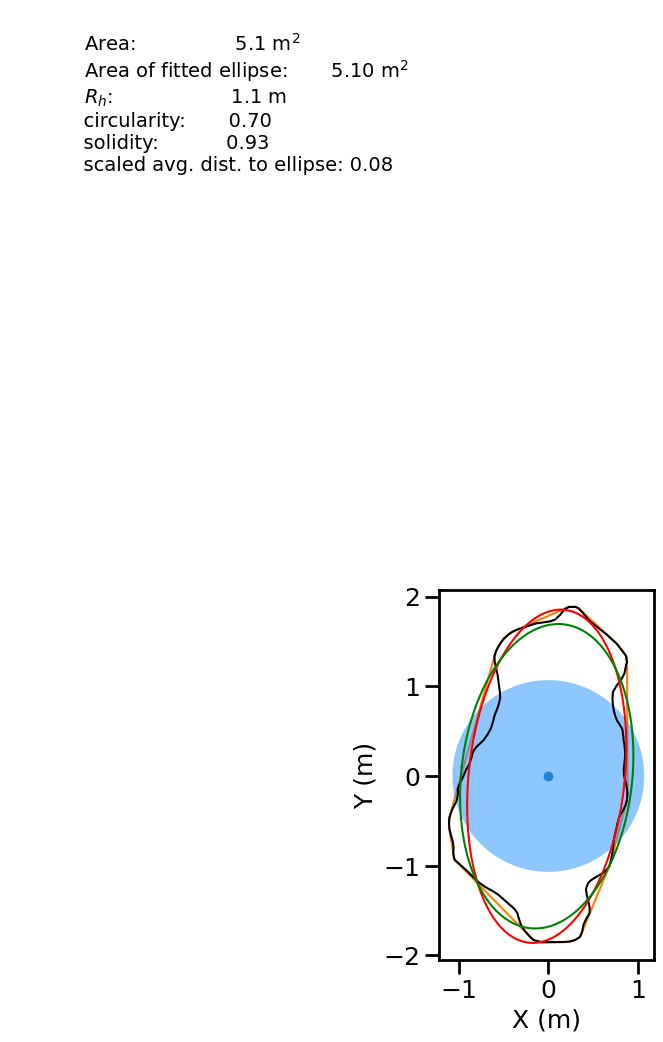

In [12]:

fig, ax = plt.subplots()
ordered[12].fitEllipse()
ordered[12].plot_basic(ax)

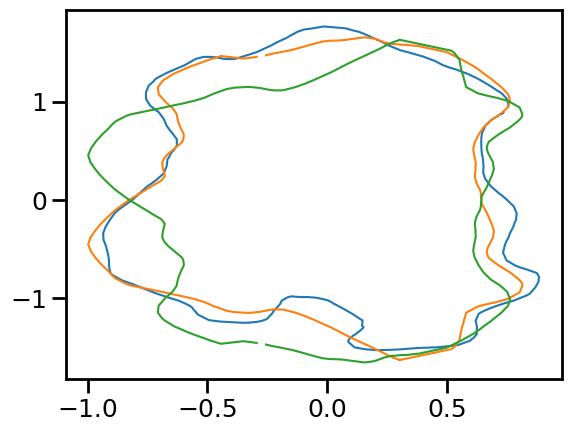

In [13]:
plt.plot(s0.points2d[:, 0], s0.points2d[:, 1])
plt.plot(s1.points2d[:, 0], s1.points2d[:, 1])

plt.plot(flipped[:, 0], flipped[:, 1])